In [130]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import rsciio.digitalmicrograph as dm
import matplotlib.pyplot as plt


In [131]:
path_to_data = "../data/008_core_loss_line_020evpx_1mm.dm3"

raw_data = dm.file_reader(path_to_data)

# Extracting the core loss data
core_loss_data = raw_data[0]['data']

# Extracting the energy loss axis and spatial axis
energy_loss_md = raw_data[0]['axes'][1]
begin, dispersion, size = energy_loss_md['offset'], energy_loss_md['scale'], energy_loss_md['size']
energy_loss_axis = np.linspace(begin, begin + dispersion * (size - 1), size)

spatial_md = raw_data[0]['axes'][0]
begin, step, size = spatial_md['offset'], spatial_md['scale'], spatial_md['size']
spatial_axis = np.linspace(begin, begin + step * (size - 1), size)

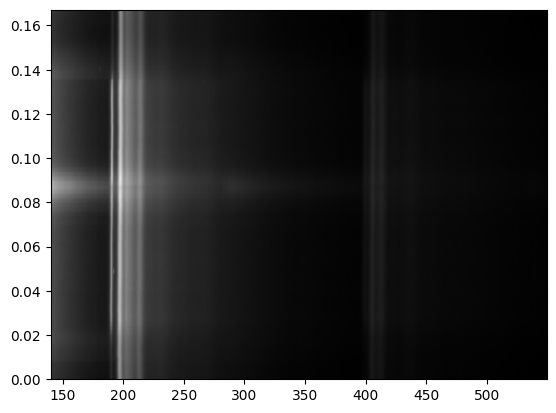

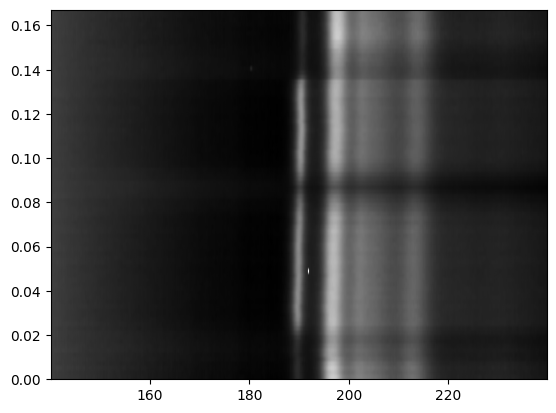

In [132]:
plt.imshow(core_loss_data, cmap='gray', aspect='auto', extent=
        [energy_loss_axis[0], energy_loss_axis[-1], spatial_axis[0], spatial_axis[-1]])
plt.show()
# core_loss_data_trimmed = np.concatenate((core_loss_data[:14,1500:], core_loss_data[75:,1500:]))
core_loss_data_trimmed = core_loss_data[:, :500]
core_loss_data_trimmed /= core_loss_data_trimmed[:,0].reshape(-1, 1)
energy_loss_axis_trimmed = energy_loss_axis[:500]
plt.imshow(core_loss_data_trimmed, cmap='gray', aspect='auto', extent=
        [energy_loss_axis_trimmed[0], energy_loss_axis_trimmed[-1], spatial_axis[0], spatial_axis[-1]])

In [ ]:
intensities = torch.tensor(core_loss_data_trimmed, dtype=torch.float32)  
energy_axis = torch.tensor(energy_loss_axis_trimmed, dtype=torch.float32)
spatial_axis = torch.tensor(spatial_axis, dtype=torch.float32)

exclude_min = 185
exclude_max = 220
mask = (energy_axis < exclude_min) | (energy_axis > exclude_max)

# Filter according to mask
filtered_energy_axis = energy_axis[mask]
filtered_intensities = intensities[:, mask]

# Get shapes
num_spectra, num_energy_loss = filtered_intensities.shape

# Log of total intensity per spectrum
log_total_intensity = torch.log(filtered_intensities.sum(dim=1, keepdim=True))

# Expand to match each spectrum
energy_axis_expanded = filtered_energy_axis.unsqueeze(0).expand(num_spectra, -1)
log_total_intensity_expanded = log_total_intensity.expand(-1, num_energy_loss)

# Stack energy and log_intensity into input features
X = torch.stack([
    energy_axis_expanded, 
    log_total_intensity_expanded
], dim=2)
X = X.reshape(-1, 2)

# Flatten intensities to shape
y = torch.log(filtered_intensities.reshape(-1))

# Compute mean and std along each feature (dim=0 means per column)
X_mean = X.mean(dim=0)
X_std = X.std(dim=0)

# Normalize
X = (X - X_mean) / X_std

y_mean = y.mean()
y_std = y.std()

# Normalize
y = (y - y_mean) / y_std

print(y)


tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, 

C:\Users\bartv\AppData\Local\Temp\ipykernel_4536\1222527154.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  spatial_axis = torch.tensor(spatial_axis, dtype=torch.float32)


In [134]:
class EELSBackgroundNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 10),
            nn.Sigmoid(),
            nn.Linear(10, 15),
            nn.Sigmoid(),
            nn.Linear(15, 5),
            nn.Sigmoid(),
            nn.Linear(5, 1),
        )
    def forward(self, x):
        return self.model(x)

In [135]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EELSBackgroundNet().to(device)
X, y = X.to(device), y.to(device)

print("Using device:", device)
print("Input shape:", X.shape)
print("Target shape:", y.shape)


# Loss function and optimizer
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Training loop
n_epochs = 20
cost = []
for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0.0
    
    for batch_X, batch_y in dataloader:
        # Forward pass
        predictions = model(batch_X).squeeze()

        # Loss
        loss = loss_function(predictions, batch_y)
        epoch_loss += loss.item()

        # Backward + optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    cost.append(epoch_loss)
    # Print epoch stats
    # if (epoch + 1) % 10 == 0 or epoch == 0:
    print(f"Epoch {epoch + 1}/{n_epochs}, Loss: {epoch_loss:.4f}")


Using device: cuda
Input shape: torch.Size([27216, 2])
Target shape: torch.Size([27216])
Epoch 1/20, Loss: 425.1530
Epoch 2/20, Loss: 398.5873
Epoch 3/20, Loss: 245.8988
Epoch 4/20, Loss: 199.1539
Epoch 5/20, Loss: 197.0932
Epoch 6/20, Loss: 196.4012
Epoch 7/20, Loss: 195.6377
Epoch 8/20, Loss: 194.7629
Epoch 9/20, Loss: 194.0707
Epoch 10/20, Loss: 193.3693
Epoch 11/20, Loss: 192.8104
Epoch 12/20, Loss: 192.0947
Epoch 13/20, Loss: 191.9219
Epoch 14/20, Loss: 191.4816
Epoch 15/20, Loss: 191.1709
Epoch 16/20, Loss: 190.9522
Epoch 17/20, Loss: 190.6472
Epoch 18/20, Loss: 190.6102
Epoch 19/20, Loss: 190.7364
Epoch 20/20, Loss: 190.3357


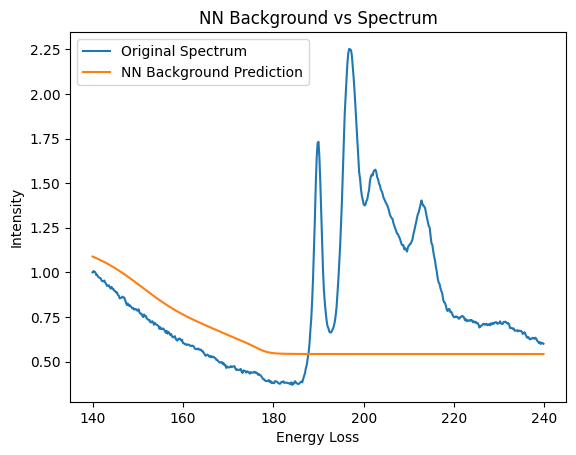

In [136]:
spectrum = intensities[50]
log_total = torch.log(spectrum.sum())
X_single = torch.stack([
    energy_axis, 
    log_total.expand_as(energy_axis)
], dim=1)

X_single = (X_single - X_mean) / X_std

model.eval()
with torch.no_grad():
    pred_log = model(X_single.to(device)).squeeze()

pred_log = pred_log * y_std + y_mean
pred = torch.exp(pred_log)

import matplotlib.pyplot as plt

plt.plot(energy_axis.cpu(), spectrum.cpu(), label="Original Spectrum")
plt.plot(energy_axis.cpu(), pred.cpu(), label="NN Background Prediction")
plt.xlabel("Energy Loss")
plt.ylabel("Intensity")
plt.legend()
plt.title("NN Background vs Spectrum")
plt.show()



Text(0, 0.5, 'Loss')

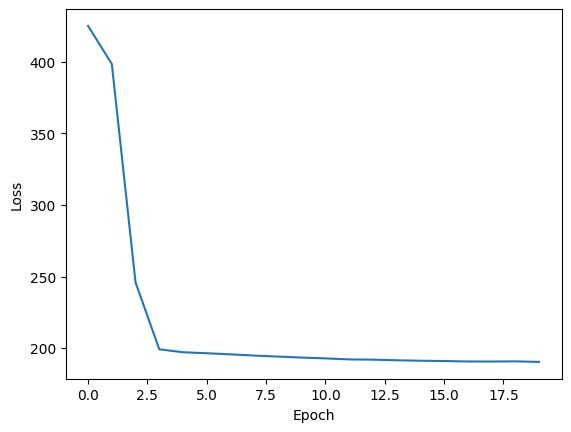

In [ ]:
plt.plot(cost, label="Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")